In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import torch
import random
import numpy as np
import gc

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

gc.collect()
torch.cuda.empty_cache()

In [2]:
import torch
import torch.nn as nn

def positional_encoding_2d(H, W, device='cpu'):
    pos = torch.zeros(H*W, 2).to(device)
    idx = 0
    for i in range(H):
        for j in range(W):
            pos[idx] = torch.tensor([i / H, j / W])
            idx += 1
    return pos  # shape (H*W, 2)

class MLP(nn.Module):
    def __init__(
        self, 
        H=21, W=34, C=12, 
        dim=256, depth=4,
        mask=None,
        dropout=0.0
    ):
        super().__init__()

        self.H = H
        self.W = W
        self.C = C

        # ---- 1) Mask ----
        if mask is None:
            mask = torch.ones(H, W, dtype=torch.bool)

        flat_mask = mask.view(-1)
        self.register_buffer("flat_mask", flat_mask)
        self.register_buffer("keep_idx", flat_mask.nonzero(as_tuple=True)[0])

        self.Nkeep = len(self.keep_idx)

        # ---- Positional encoding ----
        full_pos = positional_encoding_2d(H, W)
        self.register_buffer("pos", full_pos)

        # ---- Input projection ----
        self.in_proj = nn.Linear(C + 2, dim)
        self.in_dropout = nn.Dropout(dropout)

        # ---- Build MLP layers ----
        layers = []
        for _ in range(depth):
            layers.append(nn.Linear(dim, dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)

        # ---- Output projection ----
        self.out_proj = nn.Linear(dim, 1)
        self.out_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)

        # Flatten → (B, 714, C)
        x = x.view(B, self.C, self.H * self.W).permute(0, 2, 1)

        # Positional encoding
        pos = self.pos.unsqueeze(0).expand(B, -1, -1)
        x = torch.cat([x, pos], dim=-1)

        # Keep only masked tokens
        x = x[:, self.keep_idx, :]   # (B, Nkeep, C+2)

        # Input projection
        x = self.in_proj(x)
        x = self.in_dropout(x)

        # MLP layers
        x = self.mlp(x)

        # Output layer
        x = self.out_proj(x)
        x = self.out_dropout(x)

        # Scatter back to full grid
        out = torch.zeros(B, self.H * self.W, 1, device=x.device)
        out[:, self.keep_idx] = x

        return out.view(B, 1, self.H, self.W)

In [3]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(
        self, 
        H=36, W=49, C=12, 
        dim=64, depth=4, heads=4, 
        mask=None,
        dropout=0.0
    ):
        super().__init__()

        self.H = H
        self.W = W
        self.C = C

        # ---- 1) Fixed mask ----
        if mask is None:
            mask = torch.ones(H, W, dtype=torch.bool)

        flat_mask = mask.view(-1)
        self.register_buffer("flat_mask", flat_mask)
        self.register_buffer("keep_idx", flat_mask.nonzero(as_tuple=True)[0])
        self.Nkeep = len(self.keep_idx)

        # ---- Positional encoding ----
        full_pos = positional_encoding_2d(H, W)
        self.register_buffer("pos", full_pos)

        # ---- Projection + dropout ----
        self.in_proj = nn.Linear(C + 2, dim)
        self.in_dropout = nn.Dropout(dropout)

        # ---- Transformer Encoder (POST-NORM) ----
        enc_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=dim * 4,
            batch_first=True,
            dropout=dropout,
            activation="relu",
        )
        self.encoder = nn.TransformerEncoder(
            enc_layer,
            num_layers=depth
        )

        # ---- Output projection ----
        self.out_proj = nn.Linear(dim, 1)
        self.out_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B = x.size(0)

        # (B, C, H, W) → (B, H*W, C)
        x = x.view(B, self.C, self.H * self.W).permute(0, 2, 1)

        # Add positional encoding → (B, H*W, C+2)
        pos = self.pos.unsqueeze(0).expand(B, -1, -1)
        x = torch.cat([x, pos], dim=-1)

        # ---- Select masked tokens ----
        x = x[:, self.keep_idx, :]     # (B, Nkeep, C+2)

        # ---- Projection ----
        x = self.in_proj(x)            # (B, Nkeep, dim)
        x = self.in_dropout(x)

        # ---- Transformer encoder ----
        x = self.encoder(x)            # (B, Nkeep, dim)

        # ---- Output projection ----
        x = self.out_proj(x)           # (B, Nkeep, 1)
        x = self.out_dropout(x)

        # ---- Scatter back ----
        out = torch.zeros(B, self.H * self.W, 1, device=x.device)
        out[:, self.keep_idx] = x

        return out.view(B, 1, self.H, self.W)


In [4]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return F.softplus(self.conv(x))

# network

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):

    def __init__(self, n_channels, n_classes, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [6]:
class CNN(nn.Module):

    def __init__(self, in_channels=12, base_filters=32):
        super(CNN, self).__init__()

        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, base_filters, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),

            # Block 2
            nn.Conv2d(base_filters, base_filters * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_filters * 2),
            nn.ReLU(inplace=True),

            # Block 3
            nn.Conv2d(base_filters * 2, base_filters * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters * 4, base_filters * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters * 4),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(base_filters * 4, base_filters * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters * 2),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_filters * 2, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),

            nn.Conv2d(base_filters, 1, kernel_size=1)
        )

    def forward(self, x):
        # Bỏ dimension thừa nếu có
        if x.dim() == 5:
            x = x.squeeze(1)
        
        original_size = (x.shape[2], x.shape[3])  # (21, 34)
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        rainfall = F.interpolate(decoded, size=original_size, mode='bilinear', align_corners=False)
        
        return rainfall

# loss

In [7]:
import torch
import torch.nn as nn


class RainfallLoss(nn.Module):
    def __init__(self, mask, mse_weight=0.7, mae_weight=0.3):
        super().__init__()
        self.register_buffer('mask', mask)
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
        
        if self.mask.sum() == 0:
            raise ValueError("ERROR: Mask has 0 valid pixels!")
        
        print(f"\nRainfallLoss initialized:")
        print(f"  Valid pixels: {self.mask.sum():.0f}")
        print(f"  MSE weight: {self.mse_weight}, MAE weight: {self.mae_weight}")
        
    def forward(self, pred, target):
        # Safety check
        if torch.isnan(pred).any():
            print("⚠️  NaN in predictions!")
            pred = torch.nan_to_num(pred, nan=0.0)
        if torch.isnan(target).any():
            print("⚠️  NaN in targets!")
            target = torch.nan_to_num(target, nan=0.0)
        
        # Expand mask: (H,W) -> (B,H,W)
        mask_expanded = self.mask.unsqueeze(0).expand_as(pred)
        
        # Apply mask
        pred_masked = pred * mask_expanded
        target_masked = target * mask_expanded
        
        # Calculate loss - chia cho tổng số valid pixels trong batch
        batch_size = pred.size(0)

        weights = torch.where(target_masked > 0, torch.tensor(10.0, device=pred.device), torch.tensor(1.0, device=pred.device)) * mask_expanded
        # print(target_masked.shape)
        # print(sum((target_masked[0].flatten() > 0)))
        # print(sum((target_masked[0].flatten() == 0)))

        total_weight = weights.sum() * batch_size
        
        mse = ((pred_masked - target_masked) ** 2 * weights).sum() / total_weight
        mae = (torch.abs(pred_masked - target_masked) * weights).sum() / total_weight
        
        loss = self.mse_weight * mse + self.mae_weight * mae
        
        # Final safety check
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️  NaN/Inf in loss! MSE={mse.item():.4f}, MAE={mae.item():.4f}")
            return torch.tensor(0.0, device=pred.device, requires_grad=True)
        
        return loss
    

In [8]:

from torch.utils.data import Dataset
import random

class RainDataset(Dataset):
    def __init__(self, X, Y, augmentation=False):
        """
        X: Tensor (N, C, H, W)
        Y: Tensor (N, H, W)
        augmentation: True/False
        """
        assert len(X) == len(Y), "X và Y phải cùng số lượng sample"

        self.X = X
        self.Y = Y
        self.aug = augmentation

    def __len__(self):
        return len(self.X)

    def augment(self, x, y):
        """
        x: (C, H, W)
        y: (H, W)
        """

        # --- Flip theo chiều H (vertical) ---
        if random.random() < 0.5:
            x = torch.flip(x, dims=[1])   # H: dim=1
            y = torch.flip(y, dims=[0])   # H: dim=0

        # --- Flip theo chiều W (horizontal) ---
        if random.random() < 0.5:
            x = torch.flip(x, dims=[2])   # W: dim=2
            y = torch.flip(y, dims=[1])   # W: dim=1

        # --- Rotate 180° (an toàn, giữ nguyên shape) ---
        if random.random() < 0.3:
            x = torch.rot90(x, k=2, dims=[1, 2])  # xoay theo H,W
            y = torch.rot90(y, k=2, dims=[0, 1])

        # --- Gaussian noise ---
        if random.random() < 0.3:
            x = x + torch.randn_like(x) * 0.01

        return x, y

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]

        # shape Y đang là (H, W) → thêm channel 1 nếu bạn muốn
        # nhưng bạn nói dataset là (N, H, W) nên để nguyên

        if self.aug:
            x, y = self.augment(x, y)

        return x, y

# LR

In [9]:
# learning_rate_schedule.py
import math
import torch

class MyScheduler(torch.optim.lr_scheduler.LRScheduler):
    """
    Warmup theo ratio + step-based decay (linear, cosine, exponential)
    Đảm bảo LR cuối cùng = base_lr * final_lr_ratio chính xác.
    """
    def __init__(self, optimizer, total_steps, warmup_ratio=0.1,
                 scheduler_type="cosine", gamma=0.1, final_lr_ratio=0.1, last_epoch=-1):

        self.scheduler_type = scheduler_type.lower()
        self.gamma = gamma
        self.warmup_steps = max(1, int(total_steps * warmup_ratio))
        self.total_steps = total_steps
        self.final_lr_ratio = final_lr_ratio

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []

        for base_lr in self.base_lrs:
            final_lr = base_lr * self.final_lr_ratio

            # ----------------
            # 1. Warmup phase
            # ----------------
            if step <= self.warmup_steps:
                lr = base_lr * step / self.warmup_steps
                lrs.append(lr)
                continue

            # ----------------
            # 2. Decay phase
            # ----------------
            decay_step = step - self.warmup_steps
            decay_total = self.total_steps - self.warmup_steps
            t = decay_step / decay_total  # normalized: 0 → 1

            if self.scheduler_type == "linear":
                # linear decay từ base_lr → final_lr
                lr = base_lr + (final_lr - base_lr) * t

            elif self.scheduler_type == "cosine":
                # cosine, nhưng scale để cuối = final_lr
                cosine = 0.5 * (1 + math.cos(math.pi * t))
                # scale để cosine(0)=1, cosine(1)=final_lr/base_lr
                lr = final_lr + (base_lr - final_lr) * cosine

            elif self.scheduler_type == "exponential":
                # exponential thật sự luôn giảm đúng từ base_lr → final_lr
                # base_lr * k^(decay_total) = final_lr  => k = (final_lr/base_lr)^(1/decay_total)
                k = (final_lr / base_lr) ** (1 / decay_total)
                lr = base_lr * (k ** decay_step)

            else:
                raise ValueError(f"Scheduler type {self.scheduler_type} not supported")

            lrs.append(lr)

        return lrs

    def step(self, epoch=None):
        super().step(epoch)

# ===========================
# Example usage
# ===========================


# path

In [10]:
import numpy as np
from scipy import ndimage

def fill_nodata_nearest_hw(y, nodata=-9999):
    y = y.copy()
    B, H, W = y.shape

    for b in range(B):
        hw = y[b]
        mask = hw == nodata

        if not mask.any():
            continue

        _, indices = ndimage.distance_transform_edt(
            mask, return_indices=True
        )

        hw[mask] = hw[tuple(indices)][mask]

    return y

# Đọc data
X = np.load('/kaggle/input/data-hatinh-np/x_direct.npy')
Y = np.load('/kaggle/input/data-hatinh-np/y_direct.npy')
mask = Y[0] != -1
valid_idx = np.any(Y[:, mask] != 0, axis=(1))
X = X[valid_idx]
Y = Y[valid_idx]
# mask_x = np.load('/kaggle/input/data-hatinh-mask/hatinh_mask_x.npy')
# mask_y = np.load('/kaggle/input/data-hatinh-mask/hatinh_mask_y.npy')
# mask = np.load('/kaggle/input/maskhatinh/mask_hatinh.npy')
# mask = np.ones((90, 250), dtype=np.int32)
y_time = np.load('/kaggle/input/data-hatinh-np/y_t4_t10.npy')
y_time = y_time[valid_idx]
# # Kiểm tra shape
# print(f"X shape: {X.shape}")  # (884, 34, 21, 34)
# print(f"Y shape: {Y.shape}")  # (884, 21, 34)
# print(f"X dtype: {X.dtype}")
# print(f"Y dtype: {Y.dtype}")
# print(f"mask: {mask.shape}")

Y = fill_nodata_nearest_hw(Y, nodata=-9999) * mask

print(X[0][3])

[[ -1.       -1.       -1.      ...  -1.       -1.       -1.     ]
 [ -1.       -1.       -1.      ...  -1.       -1.       -1.     ]
 [ -1.       -1.       -1.      ...  -1.       -1.       -1.     ]
 ...
 [ -1.       -1.       -1.      ... 268.4981  268.4981   -1.     ]
 [ -1.       -1.       -1.      ... 266.87183  -1.       -1.     ]
 [ -1.       -1.       -1.      ...  -1.       -1.       -1.     ]]


In [11]:
# !pip install segmentation-models-pytorch

In [12]:
# import torch.nn.functional as F

# # Trong forward pass hoặc trong Dataset
# def pad_to_divisible(x, divisor=32):
#     """Pad input to be divisible by divisor"""
#     h, w = x.shape[-2:]
#     new_h = ((h - 1) // divisor + 1) * divisor
#     new_w = ((w - 1) // divisor + 1) * divisor
    
#     pad_h = new_h - h  # 32 - 21 = 11
#     pad_w = new_w - w  # 64 - 34 = 30
    
#     # Pad: (left, right, top, bottom)
#     x_padded = F.pad(x, (0, pad_w, 0, pad_h), mode='constant', value=0)
#     return x_padded, (pad_h, pad_w)

# # Wrapper model
# class PaddedUnetPlusPlus(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = smp.UnetPlusPlus(
#             encoder_name="efficientnet-b3",
#             encoder_weights="imagenet",
#             in_channels=12,
#             classes=1,
#             activation=None,
#         )
#         self.original_size = (21, 34)
    
#     def forward(self, x):
#         # Pad
#         x_padded, (pad_h, pad_w) = pad_to_divisible(x)
        
#         # Forward
#         out_padded = self.model(x_padded)
        
#         # Unpad: cắt về kích thước gốc (21, 34)
#         out = out_padded[..., :self.original_size[0], :self.original_size[1]]
#         return out

# Split data

In [13]:
import numpy as np

def stratified_split_indices(y_time, val_ratio=0.15, test_ratio=0.15):
    np.random.seed(3407)

    y_time = np.asarray(y_time)
    indices = np.arange(len(y_time))

    train_idx = []
    val_idx = []
    test_idx = []

    for label in np.unique(y_time):
        label_indices = indices[y_time == label]
        np.random.shuffle(label_indices)
    
        n = len(label_indices)
        val_size = int(n * val_ratio)
        test_size = int(n * test_ratio)
        train_size = n - val_size - test_size
    
        # Train giữ nguyên
        train_idx.append(label_indices[:train_size])
    
        # Gộp val + test rồi shuffle
        val_test = label_indices[train_size:]
        np.random.shuffle(val_test)
    
        val_idx.append(val_test[:val_size])
        test_idx.append(val_test[val_size:])

    train_idx = np.concatenate(train_idx)
    val_idx = np.concatenate(val_idx)
    test_idx = np.concatenate(test_idx)

    # Shuffle lại để trộn 0 và 1
    np.random.shuffle(train_idx)

    return train_idx, val_idx, test_idx

# Train

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader=None, 
                 criterion=None, optimizer=None, scheduler=None, 
                 mask=None,  # ← Mask cả X và Y
                 device='cuda', log_step=50, val_step=200, 
                 model_save_path='best_model.pth', gradient_clip=1.0):
        
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.mask = mask  # Mask cho Y (output)
        self.scheduler = scheduler
        self.device = device
        self.log_step = log_step
        self.val_step = val_step
        self.model_save_path = model_save_path
        self.gradient_clip = gradient_clip
        self.best_val_loss = float('inf')
        self.global_step = 0
        
        self.model.to(self.device)
        
        # Convert masks to torch tensors
        if self.mask is not None:
            if isinstance(self.mask, np.ndarray):
                self.mask = torch.from_numpy(self.mask).float()
            self.mask = self.mask.to(self.device)
            print(f"Y Mask shape: {self.mask.shape}, Valid pixels: {self.mask.sum():.0f}")
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\nModel parameters:")
        print(f"  Total: {total_params:,}")
        print(f"  Trainable: {trainable_params:,}")
    
    def get_loss(self, batch, return_output=False):
        x, target = batch
        x = x.to(self.device)
        target = target.to(self.device)
        
        # Apply mask to input X nếu có
        # if self.mask_x is not None:
        #     # mask_x shape: (H, W) -> broadcast to (B, C, H, W)
        #     x = x * self.mask_x.unsqueeze(0).unsqueeze(0)
        
        # Check inputs
        if torch.isnan(x).any() or torch.isnan(target).any():
            print("⚠️ NaN in batch data!")
            return None
        
        outputs = self.model(x)
        outputs = outputs.squeeze(1)
        
        if torch.isnan(outputs).any():
            print("⚠️ NaN in model outputs!")
            return None
        
        # Loss function sẽ tự động apply mask
        loss = self.criterion(outputs, target)

        if return_output:
            return loss, outputs
        return loss
    
    def train(self, num_epochs=10, accumulate_steps=1, save_by='loss'):
        total_batches = len(self.train_dataloader)
        total_updates = (total_batches + accumulate_steps - 1) // accumulate_steps
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'val_rmse': [],
            'val_mae': [],
            'val_corr': []
        }
        
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            
            loop = tqdm(total=total_updates, desc=f"Epoch {epoch + 1}/{num_epochs}", 
                       unit="it", ncols=100)
            update_count = 0
            
            for batch_idx, batch in enumerate(self.train_dataloader):
                self.global_step += 1
                
                loss = self.get_loss(batch)
                if loss is None:
                    print(f"Skipping batch {batch_idx}")
                    continue
                
                loss = loss / accumulate_steps
                loss.backward()
                
                if (batch_idx + 1) % accumulate_steps == 0 or (batch_idx + 1) == total_batches:
                    # Gradient clipping and norm calculation
                    if self.gradient_clip > 0:
                        total_norm = torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), self.gradient_clip)
                        if isinstance(total_norm, torch.Tensor):
                            total_norm = total_norm.item()
                    else:
                        total_norm = 0.0
                        for p in self.model.parameters():
                            if p.grad is not None:
                                total_norm += (p.grad.data.norm(2).item()) ** 2
                        total_norm = total_norm ** 0.5
                    
                    # Check NaN gradients
                    import math
                    if math.isnan(total_norm) or math.isinf(total_norm):
                        print("⚠️ NaN/Inf gradient detected! Skipping update.")
                        self.optimizer.zero_grad()
                        continue
                    
                    # Optimizer step
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
                    if self.scheduler is not None:
                        self.scheduler.step()
                    
                    running_loss += loss.item() * batch[0].size(0) * accumulate_steps
                    update_count += 1
                    loop.update(1)
                    
                    if update_count % self.log_step == 0:
                        avg_loss = running_loss / ((batch_idx + 1) * self.train_dataloader.batch_size)
                        current_lr = self.optimizer.param_groups[0]['lr']
                        tqdm.write(f"Step {self.global_step}\tLoss: {avg_loss:.6f}\t"
                                 f"Grad: {total_norm:.4f}\tLR: {current_lr:.6f}")
                    
                    if self.val_dataloader is not None and update_count % self.val_step == 0:
                        val_loss, metrics = self.validate_and_save(save_by=save_by)
                        tqdm.write(f"Val - Loss: {val_loss:.4f} | RMSE: {metrics['RMSE']:.4f} | "
                                 f"MAE: {metrics['MAE']:.4f} | Pearson: {metrics['Pearson']:.4f}")
                else:
                    running_loss += loss.item() * batch[0].size(0)
            
            # End of epoch
            epoch_train_loss = running_loss / len(self.train_dataloader.dataset)
            history['train_loss'].append(epoch_train_loss)
            
            if self.val_dataloader is not None:
                epoch_val_loss, metrics = self.validate_and_save(save_by=save_by)
                history['val_loss'].append(epoch_val_loss)
                history['val_rmse'].append(metrics['RMSE'])
                history['val_mae'].append(metrics['MAE'])
                history['val_corr'].append(metrics['Pearson'])
                
                print(f"\n{'='*60}")
                print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
                print(f"  Train Loss: {epoch_train_loss:.6f}")
                print(f"  Val Loss: {epoch_val_loss:.6f}")
                print(f"  RMSE: {metrics['RMSE']:.4f} | MAE: {metrics['MAE']:.4f} | "
                      f"Pearson: {metrics['Pearson']:.4f} | Spearman: {metrics['Spearman']:.4f}")
                print(f"{'='*60}\n")
            else:
                print(f"\nEpoch {epoch + 1}/{num_epochs}: Train Loss = {epoch_train_loss:.6f}\n")
            
            loop.close()
        
        return self.model, history
    
    def validate_and_save(self, save_by='loss'):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        
        # Lưu tất cả pred/target để tính metrics cuối
        all_preds = []
        all_targets = []
    
        with torch.no_grad():
            for batch in tqdm(self.val_dataloader, desc="Validation", leave=False):
                loss, outputs = self.get_loss(batch, return_output=True)
                if loss is None:
                    continue
                
                batch_size = batch[0].size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                x, target = batch
                x = x.to(self.device)
                target = target.to(self.device)
                
                # Lưu dự đoán và target (trong vùng mask)
                if self.mask.dim() == 2:
                    mask_expanded = self.mask.unsqueeze(0).expand_as(outputs)
                else:
                    mask_expanded = self.mask.expand_as(outputs)
                
                pred_masked = outputs[mask_expanded == 1].cpu()
                target_masked = target[mask_expanded == 1].cpu()
                
                all_preds.append(pred_masked)
                all_targets.append(target_masked)
    
        # Tính val_loss trung bình
        val_loss = total_loss / total_samples
    
        # Nối tất cả batch
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
    
        # Tính metrics trên toàn dataset
        all_metrics = self.calculate_metrics(all_preds, all_targets)
    
        # Select metric để save
        metric_map = {'loss': val_loss, 'rmse': all_metrics['RMSE'], 'mae': all_metrics['MAE']}
        current_metric = metric_map.get(save_by, val_loss)
        metric_name = save_by
    
        if current_metric < self.best_val_loss:
            self.best_val_loss = current_metric
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'val_loss': val_loss,
                'metrics': all_metrics,
                'epoch': self.global_step
            }, self.model_save_path)
            tqdm.write(f"✓ Best model saved ({metric_name}={current_metric:.6f})")
        
        self.model.train()
        return val_loss, all_metrics
    
    
    def calculate_metrics(self, pred_real, target_real):
        """
        pred_real, target_real: 1D tensor tất cả giá trị trong vùng mask
        """
        # Chuyển về giá trị thật nếu chưa expm1
        pred_real = torch.expm1(pred_real)
        target_real = torch.expm1(target_real)

        diff = pred_real - target_real

        # MSE / RMSE / MAE
        mse = (diff * diff).mean()
        rmse = torch.sqrt(mse + 1e-8)
        mae = torch.abs(diff).mean()

        # Pearson
        pred_mean = pred_real.mean()
        tar_mean = target_real.mean()
        num = ((pred_real - pred_mean) * (target_real - tar_mean)).sum()
        den = torch.sqrt(((pred_real - pred_mean)**2).sum() * ((target_real - tar_mean)**2).sum())
        pearson = num / (den + 1e-8)

        # Spearman
        def rank(x):
            order = torch.argsort(x)
            r = torch.zeros_like(order, dtype=torch.float)
            r[order] = torch.arange(len(order), device=x.device, dtype=torch.float)
            return r

        r1 = rank(pred_real)
        r2 = rank(target_real)
        d = r1 - r2
        spearman = 1 - 6*(d*d).sum() / (len(r1)*(len(r1)**2 - 1) + 1e-8)
    
        return {
            "RMSE": rmse.item(),
            "MAE": mae.item(),
            "Pearson": pearson.item(),
            "Spearman": spearman.item()
        }


# prepair datasets

In [15]:
# ==================== MAIN ====================
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print("RAINFALL PREDICTION - HÀ TĨNH PROVINCE ONLY")
    print(f"{'='*60}\n")
    
    # Load data
    # print(f"Data loaded:")
    # print(f"  X: {X.shape}, dtype={X.dtype}")
    # print(f"  Y: {Y.shape}, dtype={Y.dtype}")
    # print(f"  X range: [{X.min():.3f}, {X.max():.3f}]")
    # print(f"  Y range: [{Y.min():.3f}, {Y.max():.3f}]")

    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    VAL_BATCH_SIZE = 128
    
    # print(f"\n{'='*60}")
    # print("TRAINING CONFIG")
    # print(f"{'='*60}")
    # print(f"  Device: {DEVICE}")
    # print(f"  Batch: {BATCH_SIZE}, Epochs: {EPOCHS}")
    # print(f"  LR: {LEARNING_RATE}, Clip: {GRADIENT_CLIP}")
    # print(f"  Using X mask: {'Yes' if mask_x is not None else 'No'}")
    # print(f"  Using Y mask: {'Yes' if mask_y is not None else 'No'}")
    
    # ==================== DATA SPLIT: 70% TRAIN, 30% TEST ====================
    print(f"\n{'='*60}")
    print("DATA SPLITTING")
    print(f"{'='*60}")

    train_idx, val_idx, test_idx = stratified_split_indices(y_time, val_ratio=0.15, test_ratio=0.15)

    train_size = len(train_idx)
    val_size = len(val_idx)
    test_size = len(test_idx)

    # val_size = len(val_idx)
    # test_size = len(test_idx)
    # train_size = len(train_idx)
    
    # # Trong phần train+val, chia 10% cho val
    # val_size = int(train_val_size * 0.1)
    # train_size = train_val_size - val_size
    # train_size = len(X_shuffled) - val_size - test_size
    
    print(f"\n{'='*60}")
    print("DATA SPLIT:")
    print(f"{'='*60}")
    print(f"Total samples: {len(X)}")
    print(f"Train samples: {train_size} ({train_size/len(X)*100:.1f}%)")
    print(f"Val samples: {val_size} ({val_size/len(X)*100:.1f}%)")
    print(f"Test samples: {test_size} ({(test_size)/len(X)*100:.1f}%)")
    
    # Normalization (chỉ trên train set)
    X_train = X[train_idx]
    X_train_masked = X_train
    # X_mean = np.mean(X_train[:, :, mask_x == 1], axis=(0, 2), keepdims=True)[..., None]
    # X_std = np.std(X_train[:, :, mask_x == 1], axis=(0, 2), keepdims=True)[..., None]
    X_mean = np.mean(X_train_masked, axis=(0, 2, 3), keepdims=True)  # (1, C, 1, 1)
    X_std = np.std(X_train_masked, axis=(0, 2, 3), keepdims=True)    # (1, C, 1, 1)
    
    # Reshape để broadcast đúng với (N, C, H, W)
    # X_mean = X_mean.reshape(1, -1, 1, 1)  # (1, 12, 1, 1)
    # X_std = X_std.reshape(1, -1, 1, 1)    # (1, 12, 1, 1)
    
    X_normalized = (X - X_mean) / X_std
    
    Y_train = Y[train_idx]
    Y_train_masked = Y_train[:, mask == 1]
    Y_mean = np.mean(Y_train_masked)
    Y_std = np.std(Y_train_masked)
    
    if Y_std < 1e-3:
        print(f"⚠️  Y_std too small ({Y_std:.6f})! Using Y_std=1.0")
        Y_std = 1.0
    
    # Y_normalized = Y_shuffled / Y_mean
    Y_normalized = np.log1p(Y) #(Y_shuffled - Y_mean) / (Y_std + 1e-6)
    
    print(f"\nNormalization:")
    print(f"  Y_mean: {Y_mean:.4f}, Y_std: {Y_std:.4f}")
    print(f"  X_norm range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
    print(f"  Y_norm range: [{Y_normalized.min():.3f}, {Y_normalized.max():.3f}]")
    
    # Tính tỷ lệ pixel mưa trong mỗi mẫu
    rain_indices = []
    no_rain_indices = []
    threshold_ratio = 0.05  # Ngưỡng: ít nhất 5% pixel có mưa
    total_pixels = 21 * 34  # Số pixel trong mỗi mẫu
    
    for i in range(train_size):
        rain_pixels = np.sum(Y_train[i] > 0)
        rain_ratio = rain_pixels / total_pixels
        if rain_ratio >= threshold_ratio:
            rain_indices.append(i)
        else:
            no_rain_indices.append(i)
    
    print(f"Number of samples with rain in train set: {len(rain_indices)}")
    print(f"Number of samples without rain in train set: {len(no_rain_indices)}")
    
    # Tính trọng số cho WeightedRandomSampler
    weights = torch.zeros(train_size)
    oversample_factor = 5  # Giảm từ 10 xuống 5 để tiết kiệm RAM
    for i in rain_indices:
        weights[i] = oversample_factor * (len(no_rain_indices) / len(rain_indices))  # Tăng trọng số cho mẫu có mưa
    for i in no_rain_indices:
        weights[i] = 1.0  # Trọng số mặc định cho mẫu không mưa
    
    train_sampler = WeightedRandomSampler(weights=weights, num_samples=train_size, replacement=True)
    
    X_normalized = torch.tensor(X_normalized, dtype=torch.float32, device=DEVICE)
    Y_normalized = torch.tensor(Y_normalized, dtype=torch.float32, device=DEVICE)
    
    train_dataset = RainDataset(
        X_normalized[train_idx],
        Y_normalized[train_idx],
        augmentation=True
    )
    val_dataset = RainDataset(
        X_normalized[val_idx],
        Y_normalized[val_idx],
    )
    test_dataset = RainDataset(
        X_normalized[test_idx],
        Y_normalized[test_idx],
    )
    
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
    
    # ==================== MODEL & TRAINING ====================
    mask_torch = torch.tensor(mask, dtype=torch.float32).to(DEVICE)


RAINFALL PREDICTION - HÀ TĨNH PROVINCE ONLY


DATA SPLITTING

DATA SPLIT:
Total samples: 843
Train samples: 591 (70.1%)
Val samples: 126 (14.9%)
Test samples: 126 (14.9%)

Normalization:
  Y_mean: 0.3056, Y_std: 1.7102
  X_norm range: [-5.767, 9.069]
  Y_norm range: [-0.000, 4.754]
Number of samples with rain in train set: 367
Number of samples without rain in train set: 224


# train unet

# train transformer

In [16]:
    BATCH_SIZE = 128
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 2e-4
    WEIGHT_DECAY = 5e-5
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = Unet(n_channels=12, n_classes=1, bilinear=True)
    # model = Transformer()
    # model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.03, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_0 = 'unet.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_0,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 17,268,161
  Trainable: 17,268,161


Epoch 1/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


✓ Best model saved (rmse=1.698138)

Epoch 1/30 Summary:
  Train Loss: 0.003989
  Val Loss: 0.004248
  RMSE: 1.6981 | MAE: 1.1262 | Pearson: 0.0492 | Spearman: -0.2043



Epoch 2/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


✓ Best model saved (rmse=1.697544)

Epoch 2/30 Summary:
  Train Loss: 0.003341
  Val Loss: 0.004240
  RMSE: 1.6975 | MAE: 1.1253 | Pearson: 0.0560 | Spearman: -0.2332



Epoch 3/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


✓ Best model saved (rmse=1.675825)

Epoch 3/30 Summary:
  Train Loss: 0.003055
  Val Loss: 0.004104
  RMSE: 1.6758 | MAE: 1.0750 | Pearson: 0.0569 | Spearman: -0.2330



Epoch 4/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


✓ Best model saved (rmse=1.597461)

Epoch 4/30 Summary:
  Train Loss: 0.002788
  Val Loss: 0.003639
  RMSE: 1.5975 | MAE: 0.8838 | Pearson: 0.0835 | Spearman: -0.1824



Epoch 5/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


✓ Best model saved (rmse=1.545464)

Epoch 5/30 Summary:
  Train Loss: 0.002839
  Val Loss: 0.003329
  RMSE: 1.5455 | MAE: 0.7504 | Pearson: 0.1359 | Spearman: -0.1624



Epoch 6/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


✓ Best model saved (rmse=1.499557)

Epoch 6/30 Summary:
  Train Loss: 0.002828
  Val Loss: 0.003040
  RMSE: 1.4996 | MAE: 0.6045 | Pearson: 0.1817 | Spearman: -0.0536



Epoch 7/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


✓ Best model saved (rmse=1.489355)

Epoch 7/30 Summary:
  Train Loss: 0.002500
  Val Loss: 0.002979
  RMSE: 1.4894 | MAE: 0.5651 | Pearson: 0.1934 | Spearman: -0.0686



Epoch 8/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


✓ Best model saved (rmse=1.469759)

Epoch 8/30 Summary:
  Train Loss: 0.002600
  Val Loss: 0.002858
  RMSE: 1.4698 | MAE: 0.4481 | Pearson: 0.2199 | Spearman: 0.1161



Epoch 9/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


✓ Best model saved (rmse=1.467415)

Epoch 9/30 Summary:
  Train Loss: 0.002443
  Val Loss: 0.002901
  RMSE: 1.4674 | MAE: 0.3961 | Pearson: 0.2461 | Spearman: 0.0387



Epoch 10/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


✓ Best model saved (rmse=1.464817)

Epoch 10/30 Summary:
  Train Loss: 0.002432
  Val Loss: 0.002839
  RMSE: 1.4648 | MAE: 0.4232 | Pearson: 0.2310 | Spearman: -0.0284



Epoch 11/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]



Epoch 11/30 Summary:
  Train Loss: 0.002262
  Val Loss: 0.002865
  RMSE: 1.4751 | MAE: 0.4701 | Pearson: 0.2155 | Spearman: 0.1737



Epoch 12/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


✓ Best model saved (rmse=1.460505)

Epoch 12/30 Summary:
  Train Loss: 0.002523
  Val Loss: 0.002736
  RMSE: 1.4605 | MAE: 0.4168 | Pearson: 0.2611 | Spearman: 0.0327



Epoch 13/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


✓ Best model saved (rmse=1.452740)

Epoch 13/30 Summary:
  Train Loss: 0.002389
  Val Loss: 0.002711
  RMSE: 1.4527 | MAE: 0.4275 | Pearson: 0.2660 | Spearman: -0.0074



Epoch 14/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]



Epoch 14/30 Summary:
  Train Loss: 0.002272
  Val Loss: 0.002741
  RMSE: 1.4764 | MAE: 0.4690 | Pearson: 0.2456 | Spearman: 0.0433



Epoch 15/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]



Epoch 15/30 Summary:
  Train Loss: 0.002152
  Val Loss: 0.002788
  RMSE: 1.4608 | MAE: 0.4760 | Pearson: 0.2745 | Spearman: -0.0732



Epoch 16/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]



Epoch 16/30 Summary:
  Train Loss: 0.002139
  Val Loss: 0.002859
  RMSE: 1.5379 | MAE: 0.4959 | Pearson: 0.2235 | Spearman: 0.1326



Epoch 17/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


✓ Best model saved (rmse=1.451897)

Epoch 17/30 Summary:
  Train Loss: 0.002276
  Val Loss: 0.002818
  RMSE: 1.4519 | MAE: 0.4458 | Pearson: 0.2779 | Spearman: 0.0281



Epoch 18/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


✓ Best model saved (rmse=1.436275)

Epoch 18/30 Summary:
  Train Loss: 0.002261
  Val Loss: 0.002687
  RMSE: 1.4363 | MAE: 0.3816 | Pearson: 0.3004 | Spearman: 0.1158



Epoch 19/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]



Epoch 19/30 Summary:
  Train Loss: 0.002305
  Val Loss: 0.002816
  RMSE: 1.4507 | MAE: 0.4127 | Pearson: 0.2862 | Spearman: 0.0206



Epoch 20/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]



Epoch 20/30 Summary:
  Train Loss: 0.002109
  Val Loss: 0.002978
  RMSE: 1.4922 | MAE: 0.4920 | Pearson: 0.2714 | Spearman: 0.0727



Epoch 21/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]



Epoch 21/30 Summary:
  Train Loss: 0.002157
  Val Loss: 0.002860
  RMSE: 1.4772 | MAE: 0.4884 | Pearson: 0.2617 | Spearman: 0.0879



Epoch 22/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


✓ Best model saved (rmse=1.420219)

Epoch 22/30 Summary:
  Train Loss: 0.002307
  Val Loss: 0.002690
  RMSE: 1.4202 | MAE: 0.4156 | Pearson: 0.3355 | Spearman: -0.0334



Epoch 23/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]



Epoch 23/30 Summary:
  Train Loss: 0.002243
  Val Loss: 0.002687
  RMSE: 1.4366 | MAE: 0.4278 | Pearson: 0.3023 | Spearman: 0.0931



Epoch 24/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]



Epoch 24/30 Summary:
  Train Loss: 0.002177
  Val Loss: 0.002775
  RMSE: 1.4421 | MAE: 0.4398 | Pearson: 0.2914 | Spearman: 0.0801



Epoch 25/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]



Epoch 25/30 Summary:
  Train Loss: 0.002142
  Val Loss: 0.002862
  RMSE: 1.4523 | MAE: 0.4242 | Pearson: 0.2846 | Spearman: 0.0184



Epoch 26/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


✓ Best model saved (rmse=1.417176)

Epoch 26/30 Summary:
  Train Loss: 0.002033
  Val Loss: 0.002667
  RMSE: 1.4172 | MAE: 0.3715 | Pearson: 0.3367 | Spearman: 0.0839



Epoch 27/30: 100%|████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


✓ Best model saved (rmse=1.406481)

Epoch 27/30 Summary:
  Train Loss: 0.002058
  Val Loss: 0.002572
  RMSE: 1.4065 | MAE: 0.3776 | Pearson: 0.3572 | Spearman: 0.1619



Epoch 28/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]



Epoch 28/30 Summary:
  Train Loss: 0.001939
  Val Loss: 0.002642
  RMSE: 1.4366 | MAE: 0.3767 | Pearson: 0.3084 | Spearman: 0.1376



Epoch 29/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]



Epoch 29/30 Summary:
  Train Loss: 0.001988
  Val Loss: 0.002742
  RMSE: 1.4433 | MAE: 0.4024 | Pearson: 0.3339 | Spearman: 0.0641



Epoch 30/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


Epoch 30/30 Summary:
  Train Loss: 0.001964
  Val Loss: 0.002639
  RMSE: 1.4127 | MAE: 0.3878 | Pearson: 0.3506 | Spearman: 0.0703



In [17]:
    BATCH_SIZE = 8
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = Transformer()
    # model = Transformer()
    # model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.03, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_1 = 'transformer.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_1,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 200,961
  Trainable: 200,961


Epoch 1/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.75it/s]

Step 50	Loss: 0.049405	Grad: 0.1897	LR: 0.000008


Epoch 1/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.48it/s]


✓ Best model saved (rmse=1.492566)

Epoch 1/30 Summary:
  Train Loss: 0.050739
  Val Loss: 0.003014
  RMSE: 1.4926 | MAE: 0.5356 | Pearson: 0.1619 | Spearman: 0.0871



Epoch 2/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.73it/s]

Step 124	Loss: 0.042282	Grad: 0.2650	LR: 0.000010


Epoch 2/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.481609)

Epoch 2/30 Summary:
  Train Loss: 0.042287
  Val Loss: 0.002904
  RMSE: 1.4816 | MAE: 0.4844 | Pearson: 0.1895 | Spearman: 0.0623



Epoch 3/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.73it/s]

Step 198	Loss: 0.038874	Grad: 0.1026	LR: 0.000010


Epoch 3/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.475014)

Epoch 3/30 Summary:
  Train Loss: 0.038965
  Val Loss: 0.002854
  RMSE: 1.4750 | MAE: 0.4455 | Pearson: 0.2024 | Spearman: 0.0849



Epoch 4/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.75it/s]

Step 272	Loss: 0.039474	Grad: 0.1838	LR: 0.000010


Epoch 4/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 4/30 Summary:
  Train Loss: 0.039712
  Val Loss: 0.002856
  RMSE: 1.4759 | MAE: 0.4488 | Pearson: 0.2032 | Spearman: 0.0491



Epoch 5/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.73it/s]

Step 346	Loss: 0.041670	Grad: 0.1923	LR: 0.000010


Epoch 5/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.471349)

Epoch 5/30 Summary:
  Train Loss: 0.041368
  Val Loss: 0.002816
  RMSE: 1.4713 | MAE: 0.4393 | Pearson: 0.2130 | Spearman: 0.1097



Epoch 6/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.72it/s]

Step 420	Loss: 0.037657	Grad: 0.2981	LR: 0.000010


Epoch 6/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.470973)

Epoch 6/30 Summary:
  Train Loss: 0.038822
  Val Loss: 0.002812
  RMSE: 1.4710 | MAE: 0.4419 | Pearson: 0.2154 | Spearman: 0.0993



Epoch 7/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.73it/s]

Step 494	Loss: 0.041430	Grad: 0.1812	LR: 0.000010


Epoch 7/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 7/30 Summary:
  Train Loss: 0.038775
  Val Loss: 0.002818
  RMSE: 1.4718 | MAE: 0.4400 | Pearson: 0.2152 | Spearman: 0.0730



Epoch 8/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.74it/s]

Step 568	Loss: 0.042325	Grad: 0.1745	LR: 0.000009


Epoch 8/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 8/30 Summary:
  Train Loss: 0.042494
  Val Loss: 0.002831
  RMSE: 1.4738 | MAE: 0.4445 | Pearson: 0.2125 | Spearman: 0.0540



Epoch 9/30:  69%|███████████████████████████████████▏               | 51/74 [00:07<00:03,  6.74it/s]

Step 642	Loss: 0.040793	Grad: 0.4086	LR: 0.000009


Epoch 9/30: 100%|███████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.466324)

Epoch 9/30 Summary:
  Train Loss: 0.038146
  Val Loss: 0.002781
  RMSE: 1.4663 | MAE: 0.4224 | Pearson: 0.2262 | Spearman: 0.1352



Epoch 10/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 716	Loss: 0.042946	Grad: 0.0842	LR: 0.000009


Epoch 10/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.465916)

Epoch 10/30 Summary:
  Train Loss: 0.041126
  Val Loss: 0.002773
  RMSE: 1.4659 | MAE: 0.4421 | Pearson: 0.2312 | Spearman: 0.1541



Epoch 11/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 790	Loss: 0.037892	Grad: 0.3624	LR: 0.000009


Epoch 11/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.464148)

Epoch 11/30 Summary:
  Train Loss: 0.036798
  Val Loss: 0.002771
  RMSE: 1.4641 | MAE: 0.4117 | Pearson: 0.2317 | Spearman: 0.1520



Epoch 12/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 864	Loss: 0.042284	Grad: 0.2265	LR: 0.000008


Epoch 12/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]



Epoch 12/30 Summary:
  Train Loss: 0.040466
  Val Loss: 0.002769
  RMSE: 1.4644 | MAE: 0.4163 | Pearson: 0.2325 | Spearman: 0.1462



Epoch 13/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 938	Loss: 0.039092	Grad: 0.2567	LR: 0.000008


Epoch 13/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 13/30 Summary:
  Train Loss: 0.040171
  Val Loss: 0.002768
  RMSE: 1.4655 | MAE: 0.4444 | Pearson: 0.2351 | Spearman: 0.1542



Epoch 14/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 1012	Loss: 0.035653	Grad: 0.1511	LR: 0.000008


Epoch 14/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 14/30 Summary:
  Train Loss: 0.036193
  Val Loss: 0.002765
  RMSE: 1.4650 | MAE: 0.4513 | Pearson: 0.2381 | Spearman: 0.1605



Epoch 15/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 1086	Loss: 0.042366	Grad: 0.4404	LR: 0.000008


Epoch 15/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]



Epoch 15/30 Summary:
  Train Loss: 0.042772
  Val Loss: 0.002810
  RMSE: 1.4708 | MAE: 0.4475 | Pearson: 0.2320 | Spearman: 0.1072



Epoch 16/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 1160	Loss: 0.037658	Grad: 0.4325	LR: 0.000007


Epoch 16/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 16/30 Summary:
  Train Loss: 0.038485
  Val Loss: 0.002790
  RMSE: 1.4682 | MAE: 0.4508 | Pearson: 0.2354 | Spearman: 0.1232



Epoch 17/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 1234	Loss: 0.039738	Grad: 0.2684	LR: 0.000007


Epoch 17/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.462503)

Epoch 17/30 Summary:
  Train Loss: 0.037596
  Val Loss: 0.002769
  RMSE: 1.4625 | MAE: 0.3944 | Pearson: 0.2378 | Spearman: 0.1340



Epoch 18/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 1308	Loss: 0.038573	Grad: 0.2940	LR: 0.000007


Epoch 18/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 18/30 Summary:
  Train Loss: 0.038781
  Val Loss: 0.002759
  RMSE: 1.4635 | MAE: 0.4238 | Pearson: 0.2392 | Spearman: 0.1299



Epoch 19/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.75it/s]

Step 1382	Loss: 0.035382	Grad: 0.0553	LR: 0.000007


Epoch 19/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 19/30 Summary:
  Train Loss: 0.034985
  Val Loss: 0.002765
  RMSE: 1.4625 | MAE: 0.3881 | Pearson: 0.2371 | Spearman: 0.1255



Epoch 20/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 1456	Loss: 0.040563	Grad: 0.5294	LR: 0.000006


Epoch 20/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]



Epoch 20/30 Summary:
  Train Loss: 0.040525
  Val Loss: 0.002758
  RMSE: 1.4638 | MAE: 0.4209 | Pearson: 0.2382 | Spearman: 0.1276



Epoch 21/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 1530	Loss: 0.037042	Grad: 0.3938	LR: 0.000006


Epoch 21/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 21/30 Summary:
  Train Loss: 0.037445
  Val Loss: 0.002764
  RMSE: 1.4646 | MAE: 0.4372 | Pearson: 0.2389 | Spearman: 0.1030



Epoch 22/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 1604	Loss: 0.038103	Grad: 0.1802	LR: 0.000006


Epoch 22/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 22/30 Summary:
  Train Loss: 0.038548
  Val Loss: 0.002762
  RMSE: 1.4637 | MAE: 0.4094 | Pearson: 0.2378 | Spearman: 0.1139



Epoch 23/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.70it/s]

Step 1678	Loss: 0.034183	Grad: 0.2938	LR: 0.000006


Epoch 23/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 23/30 Summary:
  Train Loss: 0.036222
  Val Loss: 0.002772
  RMSE: 1.4652 | MAE: 0.4507 | Pearson: 0.2415 | Spearman: 0.1124



Epoch 24/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 1752	Loss: 0.037357	Grad: 0.2577	LR: 0.000006


Epoch 24/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 24/30 Summary:
  Train Loss: 0.038467
  Val Loss: 0.002792
  RMSE: 1.4678 | MAE: 0.4566 | Pearson: 0.2389 | Spearman: 0.0737



Epoch 25/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 1826	Loss: 0.036590	Grad: 0.2212	LR: 0.000005


Epoch 25/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


✓ Best model saved (rmse=1.461104)

Epoch 25/30 Summary:
  Train Loss: 0.037480
  Val Loss: 0.002743
  RMSE: 1.4611 | MAE: 0.4352 | Pearson: 0.2462 | Spearman: 0.1316



Epoch 26/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 1900	Loss: 0.039282	Grad: 0.1180	LR: 0.000005


Epoch 26/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 26/30 Summary:
  Train Loss: 0.038441
  Val Loss: 0.002758
  RMSE: 1.4629 | MAE: 0.4211 | Pearson: 0.2423 | Spearman: 0.1146



Epoch 27/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 1974	Loss: 0.034931	Grad: 0.3687	LR: 0.000005


Epoch 27/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 27/30 Summary:
  Train Loss: 0.036267
  Val Loss: 0.002747
  RMSE: 1.4616 | MAE: 0.4152 | Pearson: 0.2427 | Spearman: 0.0995



Epoch 28/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.73it/s]

Step 2048	Loss: 0.038950	Grad: 0.2011	LR: 0.000005


Epoch 28/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]



Epoch 28/30 Summary:
  Train Loss: 0.038067
  Val Loss: 0.002783
  RMSE: 1.4664 | MAE: 0.4444 | Pearson: 0.2386 | Spearman: 0.0689



Epoch 29/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 2122	Loss: 0.038550	Grad: 0.3591	LR: 0.000005


Epoch 29/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]



Epoch 29/30 Summary:
  Train Loss: 0.036231
  Val Loss: 0.002767
  RMSE: 1.4638 | MAE: 0.4118 | Pearson: 0.2383 | Spearman: 0.0529



Epoch 30/30:  69%|██████████████████████████████████▍               | 51/74 [00:07<00:03,  6.74it/s]

Step 2196	Loss: 0.035650	Grad: 0.2867	LR: 0.000005


Epoch 30/30: 100%|██████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]

✓ Best model saved (rmse=1.460123)

Epoch 30/30 Summary:
  Train Loss: 0.035534
  Val Loss: 0.002738
  RMSE: 1.4601 | MAE: 0.3999 | Pearson: 0.2436 | Spearman: 0.0868



# train cnn

In [18]:
    BATCH_SIZE = 128
    EPOCHS = 30
    GRADIENT_ACCUMULATION = 1
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 5e-5
    GRADIENT_CLIP = 1.0

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    model = CNN()
    criterion = RainfallLoss(mask_torch, mse_weight=0.7, mae_weight=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    total_updates = ((len(train_loader) + GRADIENT_ACCUMULATION - 1) // 
                     GRADIENT_ACCUMULATION) * EPOCHS
    
    scheduler = MyScheduler(
        optimizer, total_steps=total_updates,
        scheduler_type='cosine', warmup_ratio=0.03, final_lr_ratio=0.5
    )
    
    #model_path = 'best_model_dual_mask.pth'
    model_path_2 = 'cnn.pth'
    # Trainer với dual masks
    
    trainer = Trainer(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler, 
        mask=mask,  # Mask cho Y (output)
        device=DEVICE, log_step=50, val_step=100,
        model_save_path= model_path_2,
        gradient_clip=GRADIENT_CLIP
    )

    trained_model, history = trainer.train(
        num_epochs=EPOCHS,
        accumulate_steps=GRADIENT_ACCUMULATION,
        save_by='rmse'
    )


RainfallLoss initialized:
  Valid pixels: 887
  MSE weight: 0.7, MAE weight: 0.3
Y Mask shape: torch.Size([36, 49]), Valid pixels: 887

Model parameters:
  Total: 342,753
  Trainable: 342,753


Epoch 1/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.91it/s]


✓ Best model saved (rmse=1.528288)

Epoch 1/30 Summary:
  Train Loss: 0.004320
  Val Loss: 0.004295
  RMSE: 1.5283 | MAE: 0.2715 | Pearson: 0.0873 | Spearman: 0.2165



Epoch 2/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.06it/s]



Epoch 2/30 Summary:
  Train Loss: 0.003081
  Val Loss: 0.005179
  RMSE: 1.5506 | MAE: 0.3825 | Pearson: 0.0782 | Spearman: 0.1951



Epoch 3/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.68it/s]



Epoch 3/30 Summary:
  Train Loss: 0.002963
  Val Loss: 0.005780
  RMSE: 1.5656 | MAE: 0.4378 | Pearson: 0.0421 | Spearman: 0.2669



Epoch 4/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.66it/s]



Epoch 4/30 Summary:
  Train Loss: 0.003245
  Val Loss: 0.005158
  RMSE: 1.5489 | MAE: 0.4000 | Pearson: 0.1078 | Spearman: 0.2893



Epoch 5/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.23it/s]


✓ Best model saved (rmse=1.519770)

Epoch 5/30 Summary:
  Train Loss: 0.002896
  Val Loss: 0.004151
  RMSE: 1.5198 | MAE: 0.3249 | Pearson: 0.1619 | Spearman: 0.2790



Epoch 6/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.54it/s]


✓ Best model saved (rmse=1.479082)

Epoch 6/30 Summary:
  Train Loss: 0.002766
  Val Loss: 0.003236
  RMSE: 1.4791 | MAE: 0.3287 | Pearson: 0.2179 | Spearman: 0.0400



Epoch 7/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.81it/s]


✓ Best model saved (rmse=1.475620)

Epoch 7/30 Summary:
  Train Loss: 0.002928
  Val Loss: 0.003085
  RMSE: 1.4756 | MAE: 0.3254 | Pearson: 0.2227 | Spearman: 0.1801



Epoch 8/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.49it/s]


✓ Best model saved (rmse=1.474273)

Epoch 8/30 Summary:
  Train Loss: 0.002541
  Val Loss: 0.003067
  RMSE: 1.4743 | MAE: 0.3090 | Pearson: 0.2483 | Spearman: 0.1445



Epoch 9/30: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.10it/s]



Epoch 9/30 Summary:
  Train Loss: 0.002456
  Val Loss: 0.003163
  RMSE: 1.4844 | MAE: 0.3271 | Pearson: 0.2122 | Spearman: 0.0807



Epoch 10/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.18it/s]


✓ Best model saved (rmse=1.463622)

Epoch 10/30 Summary:
  Train Loss: 0.002453
  Val Loss: 0.002864
  RMSE: 1.4636 | MAE: 0.3527 | Pearson: 0.2534 | Spearman: 0.0408



Epoch 11/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.84it/s]


✓ Best model saved (rmse=1.461289)

Epoch 11/30 Summary:
  Train Loss: 0.002505
  Val Loss: 0.002865
  RMSE: 1.4613 | MAE: 0.3535 | Pearson: 0.2485 | Spearman: -0.0105



Epoch 12/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.43it/s]


✓ Best model saved (rmse=1.453342)

Epoch 12/30 Summary:
  Train Loss: 0.002498
  Val Loss: 0.002785
  RMSE: 1.4533 | MAE: 0.3598 | Pearson: 0.2636 | Spearman: 0.1160



Epoch 13/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.67it/s]



Epoch 13/30 Summary:
  Train Loss: 0.002625
  Val Loss: 0.002787
  RMSE: 1.4541 | MAE: 0.4203 | Pearson: 0.2637 | Spearman: 0.0561



Epoch 14/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.43it/s]


✓ Best model saved (rmse=1.448977)

Epoch 14/30 Summary:
  Train Loss: 0.002438
  Val Loss: 0.002720
  RMSE: 1.4490 | MAE: 0.3943 | Pearson: 0.2802 | Spearman: 0.0750



Epoch 15/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.55it/s]



Epoch 15/30 Summary:
  Train Loss: 0.002485
  Val Loss: 0.002841
  RMSE: 1.4609 | MAE: 0.3940 | Pearson: 0.2513 | Spearman: 0.0043



Epoch 16/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.98it/s]


✓ Best model saved (rmse=1.448751)

Epoch 16/30 Summary:
  Train Loss: 0.002552
  Val Loss: 0.002748
  RMSE: 1.4488 | MAE: 0.3814 | Pearson: 0.2704 | Spearman: 0.0689



Epoch 17/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.46it/s]



Epoch 17/30 Summary:
  Train Loss: 0.002297
  Val Loss: 0.002823
  RMSE: 1.4582 | MAE: 0.4018 | Pearson: 0.2474 | Spearman: -0.0175



Epoch 18/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.98it/s]



Epoch 18/30 Summary:
  Train Loss: 0.002335
  Val Loss: 0.002823
  RMSE: 1.4595 | MAE: 0.3779 | Pearson: 0.2443 | Spearman: 0.0750



Epoch 19/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.66it/s]



Epoch 19/30 Summary:
  Train Loss: 0.002167
  Val Loss: 0.002839
  RMSE: 1.4615 | MAE: 0.3675 | Pearson: 0.2518 | Spearman: 0.0693



Epoch 20/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.15it/s]



Epoch 20/30 Summary:
  Train Loss: 0.002539
  Val Loss: 0.003041
  RMSE: 1.4879 | MAE: 0.4733 | Pearson: 0.2415 | Spearman: -0.0307



Epoch 21/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.86it/s]



Epoch 21/30 Summary:
  Train Loss: 0.002280
  Val Loss: 0.003250
  RMSE: 1.5438 | MAE: 0.5231 | Pearson: 0.2341 | Spearman: 0.0756



Epoch 22/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.03it/s]



Epoch 22/30 Summary:
  Train Loss: 0.002588
  Val Loss: 0.002900
  RMSE: 1.4721 | MAE: 0.4347 | Pearson: 0.2621 | Spearman: 0.0993



Epoch 23/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.68it/s]


✓ Best model saved (rmse=1.445971)

Epoch 23/30 Summary:
  Train Loss: 0.002293
  Val Loss: 0.002725
  RMSE: 1.4460 | MAE: 0.3676 | Pearson: 0.2804 | Spearman: 0.0622



Epoch 24/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.58it/s]



Epoch 24/30 Summary:
  Train Loss: 0.002380
  Val Loss: 0.002929
  RMSE: 1.4690 | MAE: 0.4358 | Pearson: 0.2677 | Spearman: 0.0366



Epoch 25/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.93it/s]



Epoch 25/30 Summary:
  Train Loss: 0.002239
  Val Loss: 0.002756
  RMSE: 1.4483 | MAE: 0.3956 | Pearson: 0.2737 | Spearman: 0.0056



Epoch 26/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.00it/s]



Epoch 26/30 Summary:
  Train Loss: 0.002268
  Val Loss: 0.002796
  RMSE: 1.4545 | MAE: 0.4108 | Pearson: 0.2585 | Spearman: 0.0534



Epoch 27/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.10it/s]



Epoch 27/30 Summary:
  Train Loss: 0.002267
  Val Loss: 0.002824
  RMSE: 1.4536 | MAE: 0.4224 | Pearson: 0.2678 | Spearman: 0.0426



Epoch 28/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.36it/s]



Epoch 28/30 Summary:
  Train Loss: 0.002340
  Val Loss: 0.002824
  RMSE: 1.4543 | MAE: 0.3948 | Pearson: 0.2575 | Spearman: 0.0638



Epoch 29/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.78it/s]



Epoch 29/30 Summary:
  Train Loss: 0.002393
  Val Loss: 0.002950
  RMSE: 1.4777 | MAE: 0.4178 | Pearson: 0.2299 | Spearman: 0.0889



Epoch 30/30: 100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.25it/s]


Epoch 30/30 Summary:
  Train Loss: 0.002284
  Val Loss: 0.002968
  RMSE: 1.4769 | MAE: 0.4246 | Pearson: 0.2425 | Spearman: -0.0247



In [19]:
print(Y[0])

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ...  0.  0. -0.]
 [-0. -0. -0. ...  0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


EVALUATING ON TEST SET
✓ Model loaded!

Test Loss: 0.0025

TEST RESULTS (denormalized)
()
  RMSE: 1.4517
  MAE:  0.3951
  R²:   0.1704


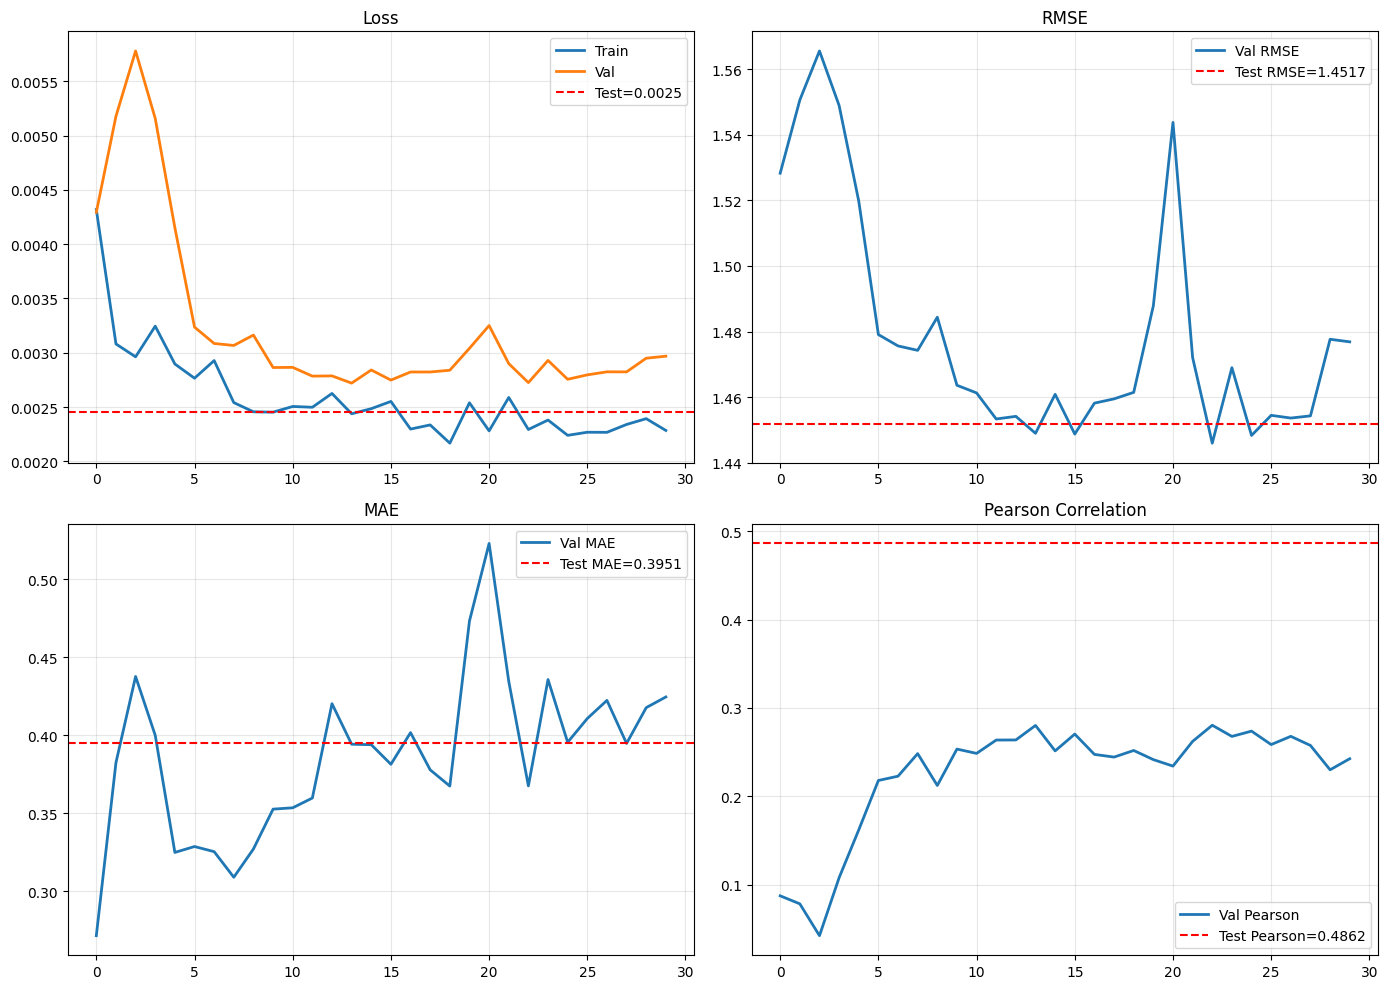

In [23]:
print("="*60)
print("EVALUATING ON TEST SET")
print("="*60)
test_model_0 = Unet(n_channels=12, n_classes=1, bilinear=True).to(DEVICE)
test_model_0.load_state_dict(torch.load("/kaggle/working/" + model_path_0, map_location=DEVICE)["model_state_dict"])
test_model_1 = Transformer().to(DEVICE)
test_model_1.load_state_dict(torch.load("/kaggle/working/" + model_path_1, map_location=DEVICE)["model_state_dict"])
test_model_2 = CNN().to(DEVICE)
test_model_2.load_state_dict(torch.load("/kaggle/working/" + model_path_2, map_location=DEVICE)["model_state_dict"])

# Load checkpoint

test_models = [test_model_0, test_model_1, test_model_2]
weights = [0.4, 0.3, 0.3]
for test_model in test_models:
    test_model.eval()

print("✓ Model loaded!\n")

# ------------------ RUN TEST ------------------
test_losses = []
all_pred_log = []
all_tgt_log = []

with torch.no_grad():
    for bx, by in test_loader:
        bx, by = bx.to(DEVICE), by.to(DEVICE)

        # ============ ENSEMBLE ============  
        outputs = []
        for model in test_models:
            outputs.append(model(bx))          # (B,1,H,W) hoặc (B,H,W)
            # print(outputs[-1])

        # weighted ensemble
        out = sum(w * o for w, o in zip(weights, outputs))
        out = out.squeeze(1)

        loss = criterion(out, by)
        test_losses.append(loss.item())

        all_pred_log.append(out.cpu().numpy())
        all_tgt_log.append(by.cpu().numpy())

all_pred_log = np.concatenate(all_pred_log, axis=0)   # (N,H,W)
all_tgt_log = np.concatenate(all_tgt_log, axis=0)

test_pred_real = np.expm1(all_pred_log)  # (N,H,W)
test_tgt_real = np.expm1(all_tgt_log)

mean_test_loss = np.mean(test_losses)
print(f"Test Loss: {mean_test_loss:.4f}")

# ==================== SUMMARY METRICS ====================
print(f"\n{'='*60}")
print("TEST RESULTS (denormalized)")
print(f"{'='*60}")

pred_masked = test_pred_real[:, mask == 1]
target_masked = test_tgt_real[:, mask == 1]

test_mse = np.mean((pred_masked - target_masked)**2)
print(test_mse.shape)
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(np.abs(pred_masked - target_masked))
test_r2 = 1 - (np.sum((target_masked - pred_masked)**2) /
               np.sum((target_masked - np.mean(target_masked))**2))
# (4) Pearson correlation
# Tính Pearson test
pred_flat = pred_masked.flatten()
target_flat = target_masked.flatten()
pearson_test = np.corrcoef(pred_flat, target_flat)[0, 1]

print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")

# ==================== PLOTTING ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (1) Loss curves
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0, 0].axhline(y=np.mean(test_losses), color='red', linestyle='--',
                   label=f"Test={np.mean(test_losses):.4f}")
axes[0, 0].set_title("Loss")
axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# (2) RMSE
axes[0, 1].plot(history['val_rmse'], label='Val RMSE', linewidth=2)
axes[0, 1].axhline(y=test_rmse, color='red', linestyle='--',
                   label=f"Test RMSE={test_rmse:.4f}")
axes[0, 1].set_title("RMSE")
axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

# (3) MAE
axes[1, 0].plot(history['val_mae'], label='Val MAE', linewidth=2)
axes[1, 0].axhline(y=test_mae, color='red', linestyle='--',
                   label=f"Test MAE={test_mae:.4f}")
axes[1, 0].set_title("MAE")
axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)

# Nếu history chưa lưu val_pearson, giả sử bạn đã lưu trong training loop:
# history['val_pearson']
axes[1, 1].plot(history['val_corr'], label='Val Pearson', linewidth=2)
axes[1, 1].axhline(y=pearson_test, color='red', linestyle='--',
                   label=f"Test Pearson={pearson_test:.4f}")
axes[1, 1].set_title("Pearson Correlation")
axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# test


[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ...  0.  0. -0.]
 [-0. -0. -0. ...  0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


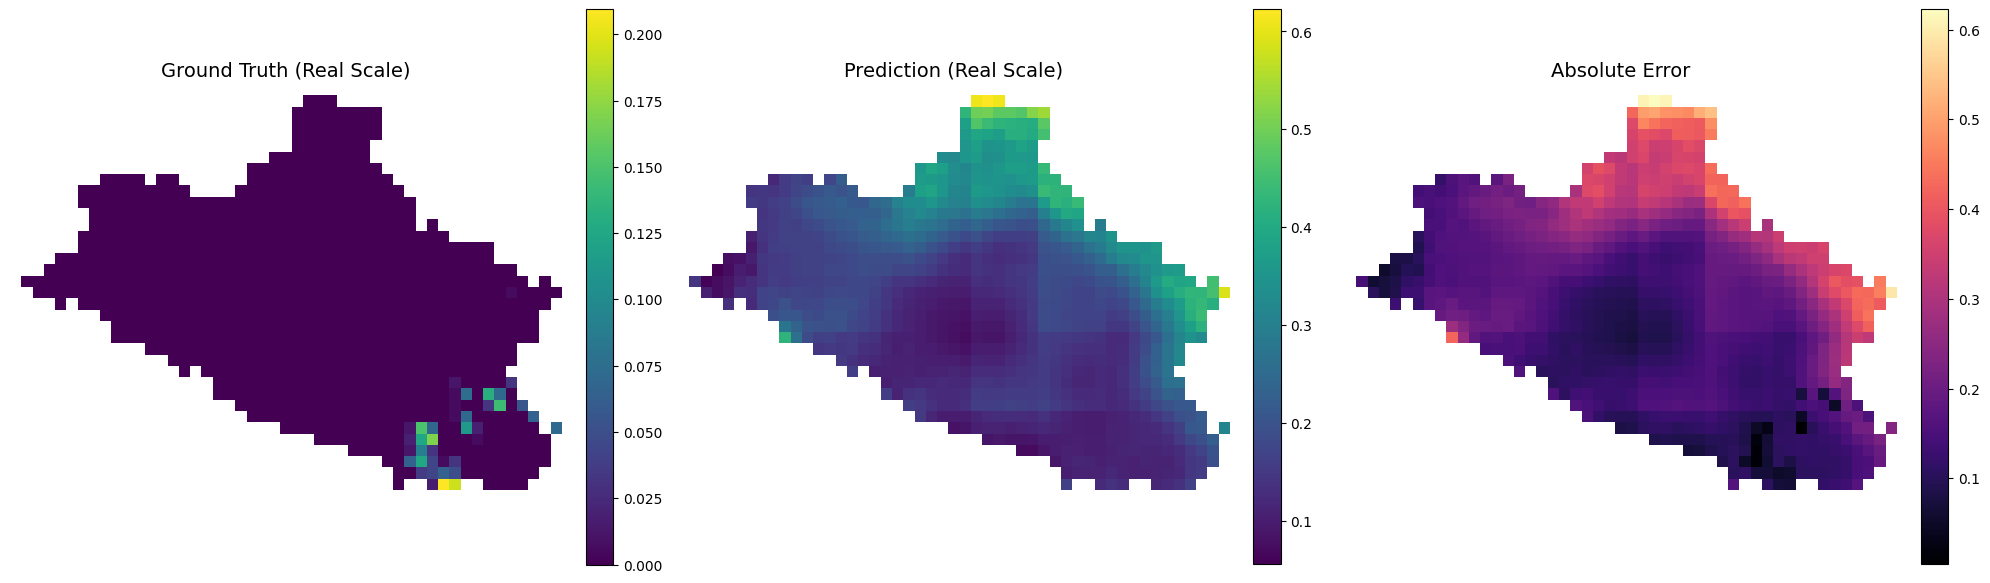

In [21]:
# ==================== FULL MAP VISUALIZATION ====================

import matplotlib.pyplot as plt
import numpy as np

# --------- CHỌN SAMPLE ---------
idx = 8   # đổi index nếu muốn xem sample khác

# --------- LẤY MAP (DENORMALIZED) ---------
gt_map = test_tgt_real[idx]     # (H, W)
pred_map = test_pred_real[idx]  # (H, W)

print(gt_map)

# --------- ÁP MASK (OPTIONAL) ---------
# Các pixel ngoài mask sẽ set = NaN để không hiển thị
gt_vis = gt_map.copy()
pred_vis = pred_map.copy()

gt_vis[mask != 1] = np.nan
pred_vis[mask != 1] = np.nan

# --------- VẼ FULL MAP ---------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Ground Truth ---
im0 = axes[0].imshow(gt_vis, cmap="viridis")
axes[0].set_title("Ground Truth (Real Scale)", fontsize=14)
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# --- Prediction ---
im1 = axes[1].imshow(pred_vis, cmap="viridis")
axes[1].set_title("Prediction (Real Scale)", fontsize=14)
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# --- Absolute Error ---
err_vis = np.abs(pred_vis - gt_vis)
im2 = axes[2].imshow(err_vis, cmap="magma")
axes[2].set_title("Absolute Error", fontsize=14)
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()